<a href="https://colab.research.google.com/github/zhamba1130/choshui_groundwater_model/blob/master/3Q9527.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi

Wed Aug  9 12:02:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!gdown  '1zGq6ApDPMB12Vwyo8uqwEk95O59_Blsz&confirm=t' --output data.zip
!gdown  '1zGq6ApDPMB12Vwyo8uqwEk95O59_Blsz&confirm=t' --output data.zip
!unzip -q data.zip

Downloading...
From: https://drive.google.com/uc?id=1zGq6ApDPMB12Vwyo8uqwEk95O59_Blsz&confirm=t
To: /content/data.zip
100% 13.0G/13.0G [02:18<00:00, 93.9MB/s]


## **Import Packages**

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import albumentations as A
from tqdm.notebook import tqdm

# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset

!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp

!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.0 MB/s eta 0:00:00


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(torch.__version__ )
print(torch.version.cuda)
print(torch.cuda.is_available())
torch.cuda.empty_cache()

2.0.1+cu118
11.8
True


## **Config**

In [ ]:
class CFG:

    # Path to the data folder (Thanks to @Kenni)
    GLOBAL_PATH = '/content'

    # base image size
    resize_value = 256

    # resize image
    resize = True
    if resize:
        resize_value = 384

    # Model Settings
    model = 'UNET'
    encoder = 'timm-resnest50d'
    weights = 'imagenet'

    batch_size = 16
    optimizer='Adam'
    lr = 5e-4
    epochs = 20

In [ ]:
#from albumentations.pytorch import ToTensorV2

train_tfm = A.Compose([
    A.Resize(256, 256),
    A.RandomCrop(224, 224),
    A.HorizontalFlip(p=0.5), # Same with transforms.RandomHorizontalFlip()
    A.VerticalFlip(p=0.1),
    A.Resize(256, 256),

    # ToTensor() should be the last one of the transforms.
    #ToTensorV2()
])

resize = A.Compose([
    A.Resize(CFG.resize_value, CFG.resize_value),
    #ToTensorV2()
])

## **Custom dataset**

In [ ]:
#A custom Dataset class must implement three functions: __init__, __len__, and __getitem__
class ContrailDataset(Dataset):

    def __init__(self, base_dir, data_type='train', transform=None):
        assert data_type in ['train_images', 'validate_images'], \
            "'data_type' should be one of 'train_images' or 'validate_images'"

        self.base_dir = base_dir
        self.data_type = data_type
        self.record = os.listdir(self.base_dir +'/'+ self.data_type)

        with open('/content/to_del.txt','r') as f:
            self.to_del = eval(f.read())

        for foldername in self.record:
            if foldername in self.to_del:
                self.record.remove(foldername) #remove the duplicate samples

        self.transform = transform
        #self.resize_image = A.Resize(CFG.resize_value, CFG.resize_value, interpolation=cv2.INTER_LANCZOS4, always_apply=True)
        #self.resize_mask = A.Resize(CFG.resize_value, interpolation=T.InterpolationMode.NEAREST, antialias=True)

    def __len__(self):
        return len(self.record)

    def __getitem__(self, idx):

        record_id = self.record[idx]
        record_dir = os.path.join(self.base_dir, self.data_type, record_id)

        false_color = np.load(os.path.join(record_dir, 'image.npy'))  #(256, 256, 3)
        human_pixel_mask = np.load(os.path.join(record_dir, 'human_pixel_masks.npy'))  #(256, 256, 1)

        # data augmentation
        if self.transform:
            augmented = self.transform(image=false_color, mask=human_pixel_mask)
            false_color = augmented['image']
            human_pixel_mask = augmented['mask']

        # resize false color image
        if CFG.resize:
            false_color = resize(image=false_color)['image']

        false_color = torch.from_numpy(false_color)#.clone().detach()          #torch.Size([256, 256, 3])
        false_color = torch.moveaxis(false_color, -1, 0)                #torch.Size([3, 256, 256])
        human_pixel_mask = torch.from_numpy(human_pixel_mask)#.clone().detach()     #torch.Size([256, 256, 1])
        human_pixel_mask = torch.moveaxis(human_pixel_mask, -1, 0)           #torch.Size([1, 256, 256])

        # false color is scaled between 0 and 1!
        return false_color, human_pixel_mask.float()

## **Dataloader**

In [ ]:
original_training_set = ContrailDataset(base_dir=CFG.GLOBAL_PATH, data_type='train_images', transform=None)   #oringinal training dataset
aug_training_set = ContrailDataset(base_dir=CFG.GLOBAL_PATH, data_type='train_images', transform=train_tfm)   #augmented training dataset
training_data = ConcatDataset([original_training_set, aug_training_set])

train_dataloader = DataLoader(
    original_training_set,
    batch_size = CFG.batch_size,
    shuffle = True,
    num_workers = 4 if torch.cuda.is_available() else 0,
    pin_memory = True,
    drop_last = True
)

validation_data = ContrailDataset(base_dir=CFG.GLOBAL_PATH, data_type='validate_images', transform=None)
validation_dataloader = DataLoader(
    validation_data,
    batch_size = CFG.batch_size,
    shuffle = False,
    num_workers = 4 if torch.cuda.is_available() else 0,
    pin_memory = True,
    drop_last = True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Show some images from the dataloader**

torch.Size([16, 3, 384, 384]) torch.Size([16, 1, 256, 256])
torch.Size([16, 384, 384, 3]) torch.Size([16, 256, 256, 1])


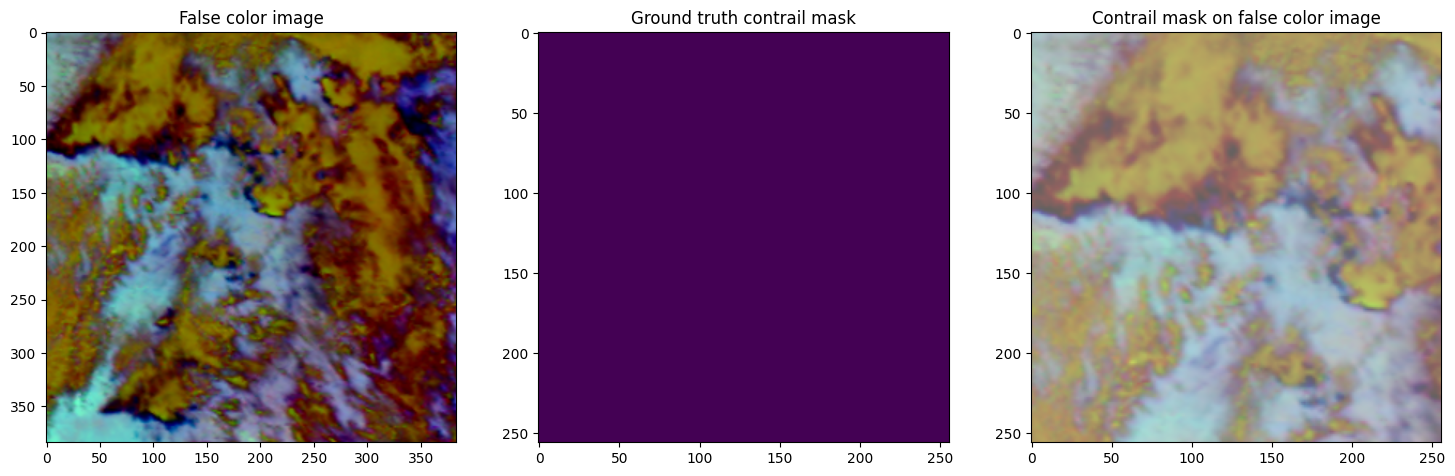

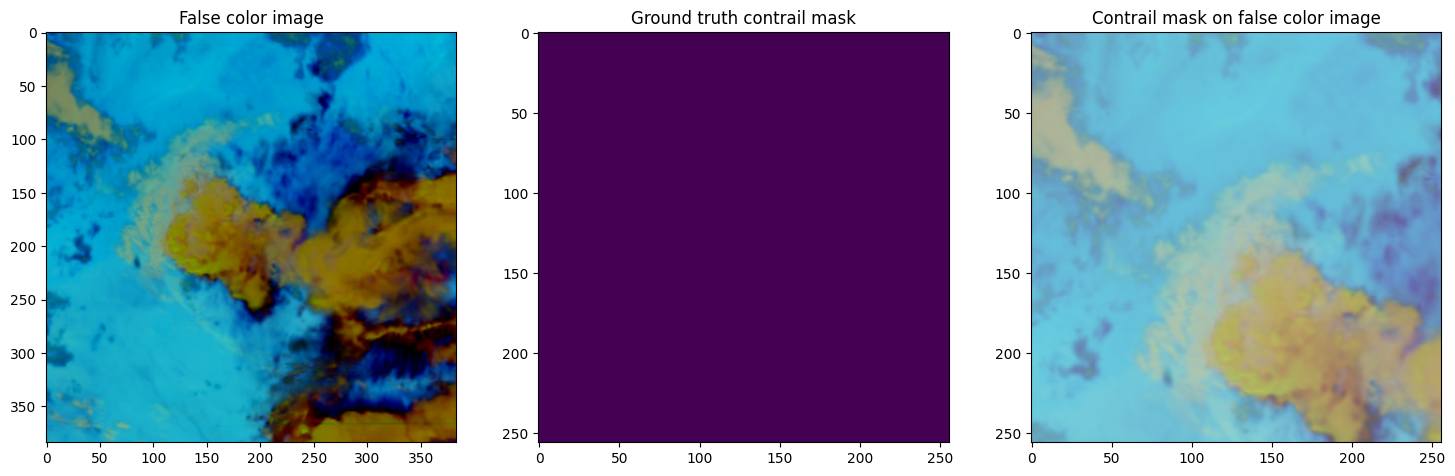

In [ ]:
image, mask = next(iter(validation_dataloader))
print(image.shape, mask.shape)

image = torch.moveaxis(image, 1, -1)
mask = torch.moveaxis(mask, 1, -1)
print(image.shape, mask.shape)

for i in range(2):

    plt.figure(figsize=(18, 6))

    ax = plt.subplot(1, 3, 1)
    ax.imshow(image[i])
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask[i], interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(image[i])
    ax.imshow(mask[i], cmap='Reds', alpha=.4, interpolation='none')
    ax.set_title('Contrail mask on false color image');

## **Create the Model (from SMP)**

In [ ]:
if CFG.model == 'UNET':
    model = smp.Unet(
        encoder_name = CFG.encoder,
        encoder_weights = CFG.weights,    # use `imagenet` pre-trained weights for encoder initialization
        in_channels = 3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes = 1,        # model output channels (number of classes in your dataset)
        activation ="sigmoid",
        )
    model.to(device)
    summary(model, (3, 256, 256))


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50-528c19ca.pth" to /root/.cache/torch/hub/checkpoints/resnest50-528c19ca.pth
100%|██████████| 105M/105M [00:00<00:00, 118MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,216
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,432
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
        MaxPool2d-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]           4,096
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

In [ ]:
#model_ckpt = '/content/drive/MyDrive/model_state_dict_epoch_11_dice_0.5845.pth'
#model.load_state_dict(torch.load(model_ckpt, map_location=torch.device('cuda')))

<All keys matched successfully>

## **Optimizer**

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
print(f'learning rate: {optimizer.param_groups[0]["lr"]}')

learning rate: 0.0005


## **Loss function**

In [ ]:
def dice_global(y_p, y_t, smooth=1e-3):
    intersection = torch.sum(y_p * y_t)
    union = torch.sum(y_p) + torch.sum(y_t)

    dice = (2.0 * intersection + smooth) / (union + smooth)

    return dice

def dice_loss_global(y_p, y_t):
    return 1 - dice_global(y_p, y_t)

# Average dice score for the examples in a batch
def dice_avg(y_p, y_t, smooth=1e-3):
    i = torch.sum(y_p * y_t, dim=(2, 3))
    u = torch.sum(y_p, dim=(2, 3)) + torch.sum(y_t, dim=(2, 3))
    score = (2 * i + smooth)/(u + smooth)
    return torch.mean(score)

def dice_loss_avg(y_p, y_t):
    return 1-dice_score_jan(y_p, y_t)

## **Training**

In [ ]:
train_dice_global, train_dice_avg = [], []
eval_dice_global, eval_dice_avg = [], []
bst_dice = 0
bst_epoch = 1
for epoch in range(1, CFG.epochs+1):

    print(f'________epoch: {epoch}________')

    # Early stopping
    if epoch-bst_epoch >=5:
        print(f'early stopping in epoch {epoch}')
        break

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # record information in training
    tot_loss_global, tot_dice_global, tot_dice_avg = 0, 0, 0

    bar = tqdm(train_dataloader)
    count = 0
    for image, mask in bar:

        #image = torch.nn.functional.interpolate(image, size=CFG.resize_value, mode='bilinear')  #already resized in dataset

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(image.to(device))
        mask = mask.to(device)

        # If the image was resized, use a resizing step to make 256 again
        if CFG.resize:
            logits = torch.nn.functional.interpolate(logits, size=256, mode='bilinear')

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Calculate the dice loss
        loss = dice_loss_global(logits, mask)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        tot_loss_global += loss.item()
        tot_dice_global += 1 - loss.item()
        tot_dice_avg += dice_avg(logits, mask).item()
        count += 1
        bar.set_postfix(TrainDiceLossGlobal=f'{tot_loss_global/count:.4f}',
                        TrainDiceGlobal=f'{tot_dice_global/count:.4f}',
                        TrainDiceAvg = f'{tot_dice_avg/count:.4f}')

    # save train results into list
    train_dice_global.append(np.array(tot_dice_global/count))
    train_dice_avg.append(np.array(tot_dice_avg/count))

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # record information in validation.
    tot_dice_global, tot_dice_avg = 0, 0

    bar = tqdm(validation_dataloader)
    count = 0
    for image, mask in bar:

        if CFG.resize:
            image = torch.nn.functional.interpolate(image, size=CFG.resize_value, mode='bilinear')

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(image.to(device))
        mask = mask.to(device)

        if CFG.resize:
            logits = torch.nn.functional.interpolate(logits, size=256, mode='bilinear')

        tot_dice_global += dice_global(logits, mask).item()
        tot_dice_avg += dice_avg(logits, mask).item()
        count += 1
        bar.set_postfix(ValidDiceGlobal=f'{tot_dice_global/count:.4f}',
                        ValidDiceAvg = f'{tot_dice_avg/count:.4f}')

    # save eval results into list
    eval_dice_global.append(np.array(tot_dice_global/count))
    eval_dice_avg.append(np.array(tot_dice_avg/count))

    scheduler.step(1-(tot_dice_global/count))
    print(f'learning rate: {optimizer.param_groups[0]["lr"]}')

    if tot_dice_global/count > bst_dice:
        bst_dice = tot_dice_global/count
        bst_epoch = epoch
        torch.save(model.state_dict(), f'/content/drive/My Drive/model_state_dict_epoch_{epoch}_dice_{bst_dice:.4f}.pth')
        torch.save(model, f'/content/drive/My Drive/model_epoch_{epoch}_dice_{bst_dice:.4f}.pt')
        print(f"current model saved! Epoch: {epoch} global dice: {bst_dice} avg dice: {tot_dice_avg/count}")


________epoch: 1________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 1 global dice: 0.48267572723217467 avg dice: 0.1191857613257839
________epoch: 2________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 3________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 3 global dice: 0.4911882469917592 avg dice: 0.14633457100918068
________epoch: 4________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 5________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 6________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 6 global dice: 0.5151489049274652 avg dice: 0.27295857667922974
________epoch: 7________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
current model saved! Epoch: 7 global dice: 0.5400436710911529 avg dice: 0.39817210774997186
________epoch: 8________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 9________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 0.0005
________epoch: 10________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
________epoch: 11________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
current model saved! Epoch: 11 global dice: 0.549472890243782 avg dice: 0.3918886038249937
________epoch: 12________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
current model saved! Epoch: 12 global dice: 0.5654211397550288 avg dice: 0.4074898038444848
________epoch: 13________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
________epoch: 14________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
current model saved! Epoch: 14 global dice: 0.5667775847283683 avg dice: 0.40092499477082283
________epoch: 15________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
current model saved! Epoch: 15 global dice: 0.5725270689369123 avg dice: 0.4219501473266503
________epoch: 16________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
________epoch: 17________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-05
________epoch: 18________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-06
________epoch: 19________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-06
current model saved! Epoch: 19 global dice: 0.5746831396233166 avg dice: 0.4425518253240092
________epoch: 20________


  0%|          | 0/1132 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

learning rate: 5e-06


<function matplotlib.pyplot.show(close=None, block=None)>

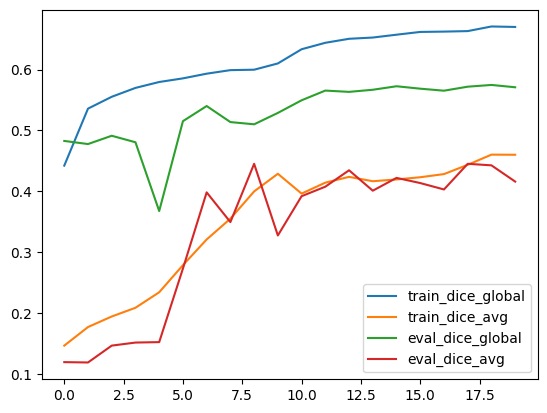

In [ ]:
plt.plot(train_dice_global, label='train_dice_global')
plt.plot(train_dice_avg, label='train_dice_avg')
plt.plot(eval_dice_global, label='eval_dice_global')
plt.plot(eval_dice_avg, label='eval_dice_avg')
plt.legend()
plt.show

## **Show some predictions for the validation dataset**

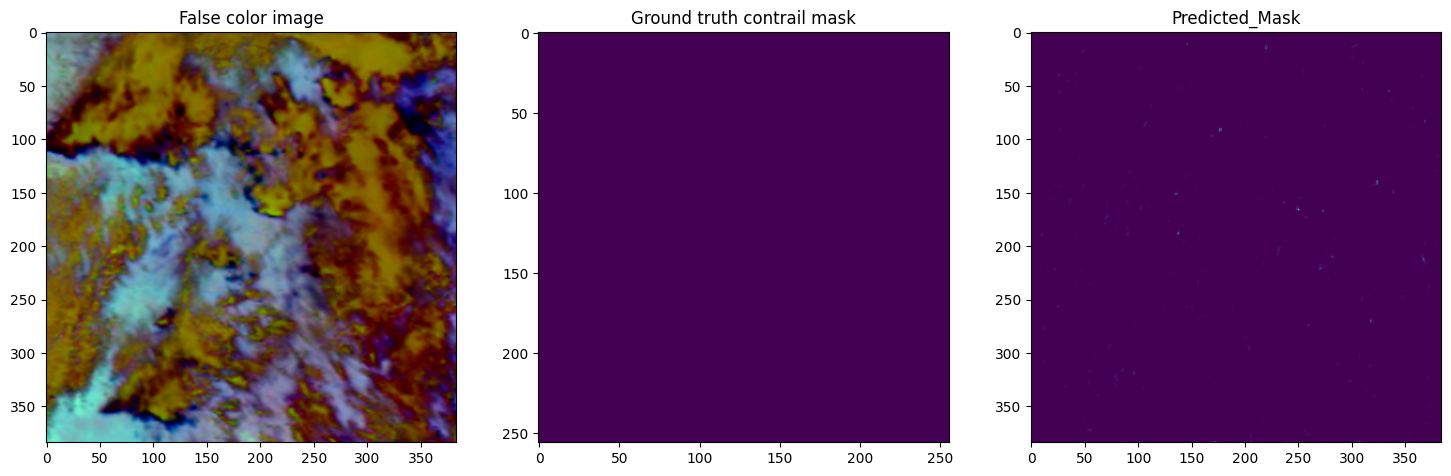

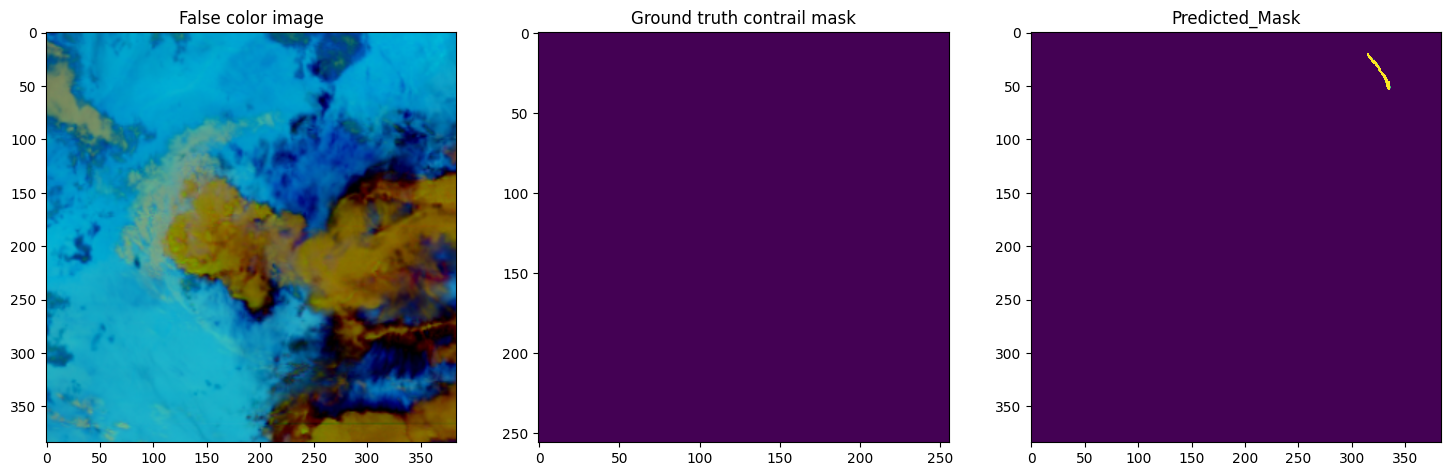

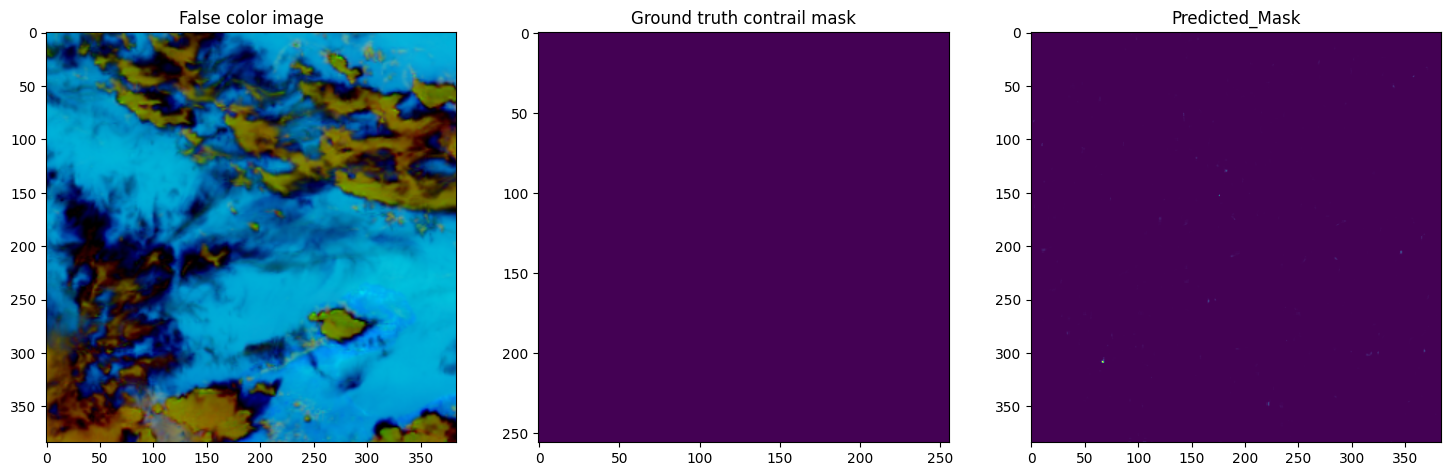

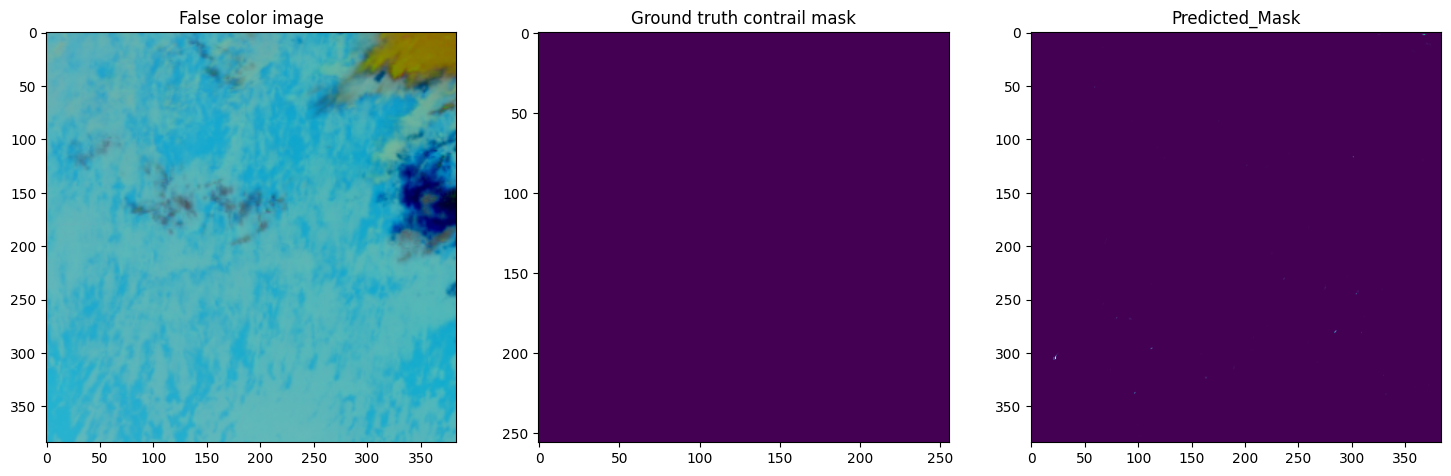

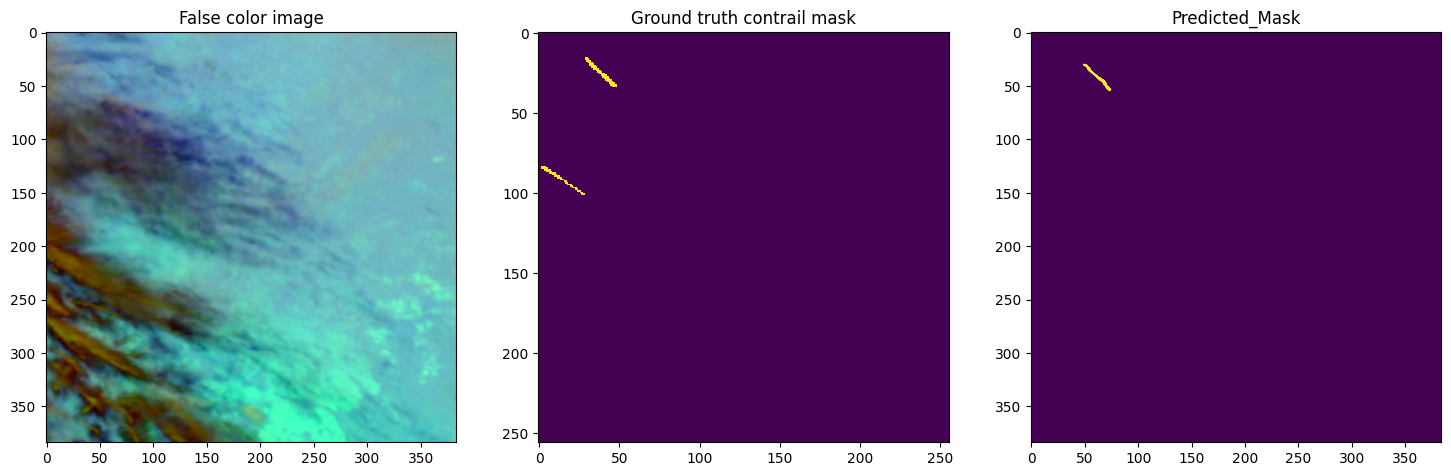

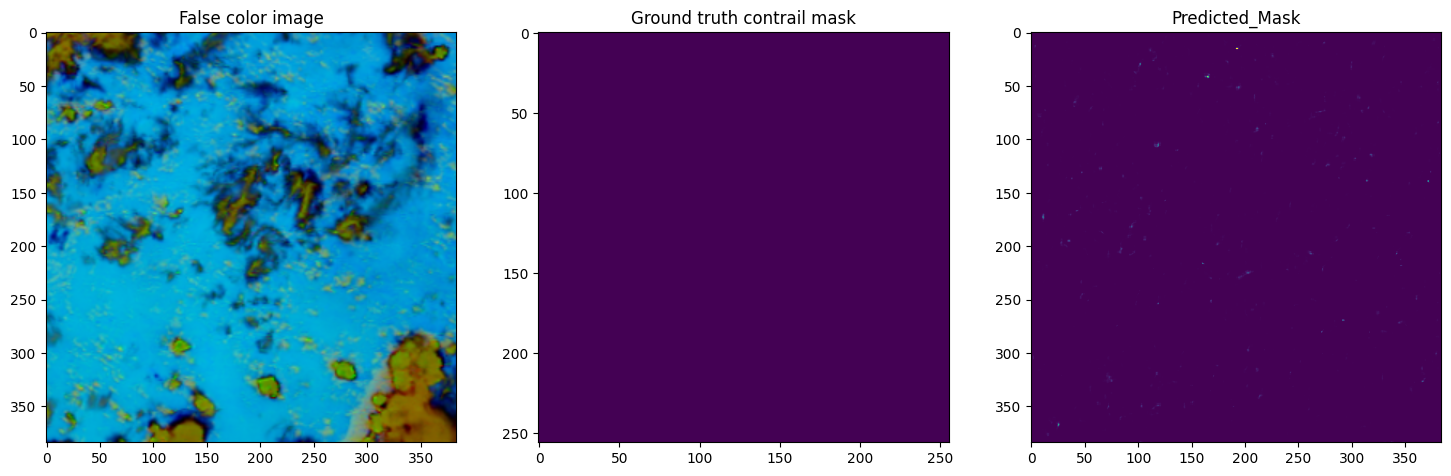

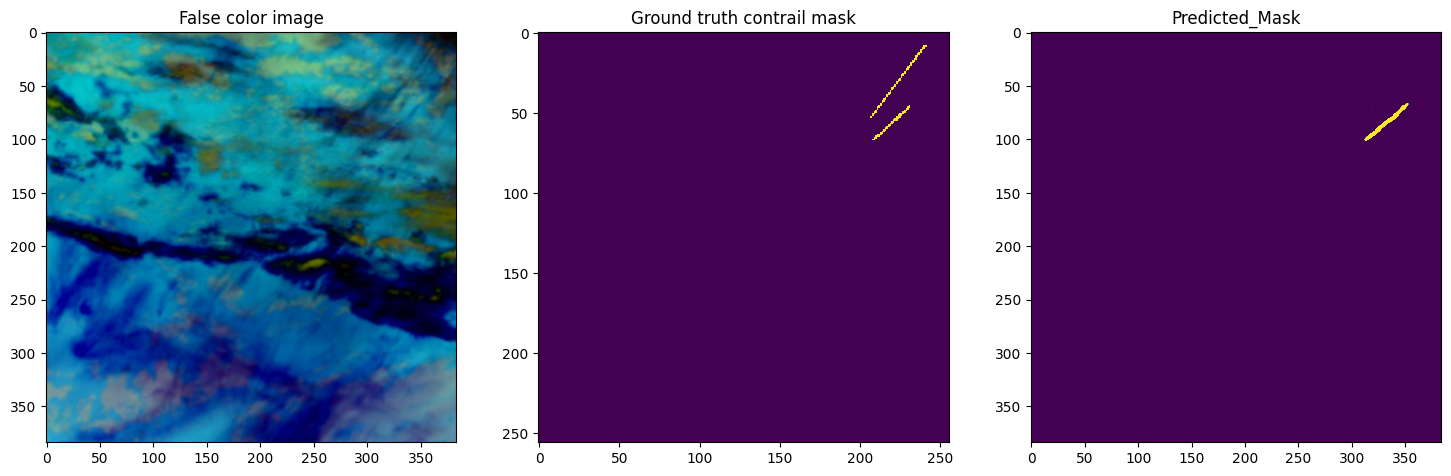

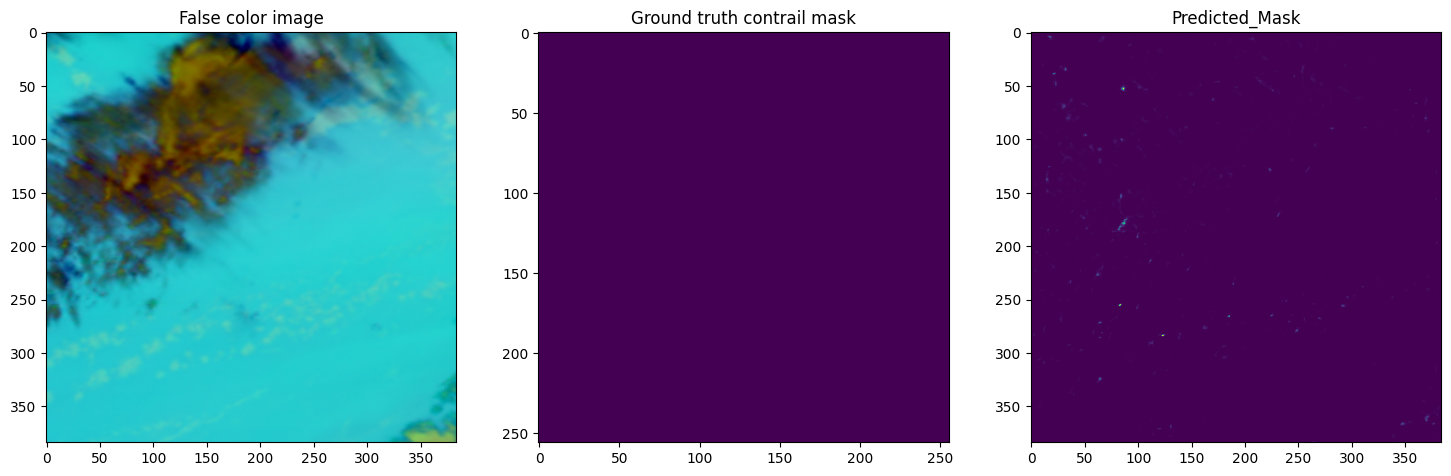

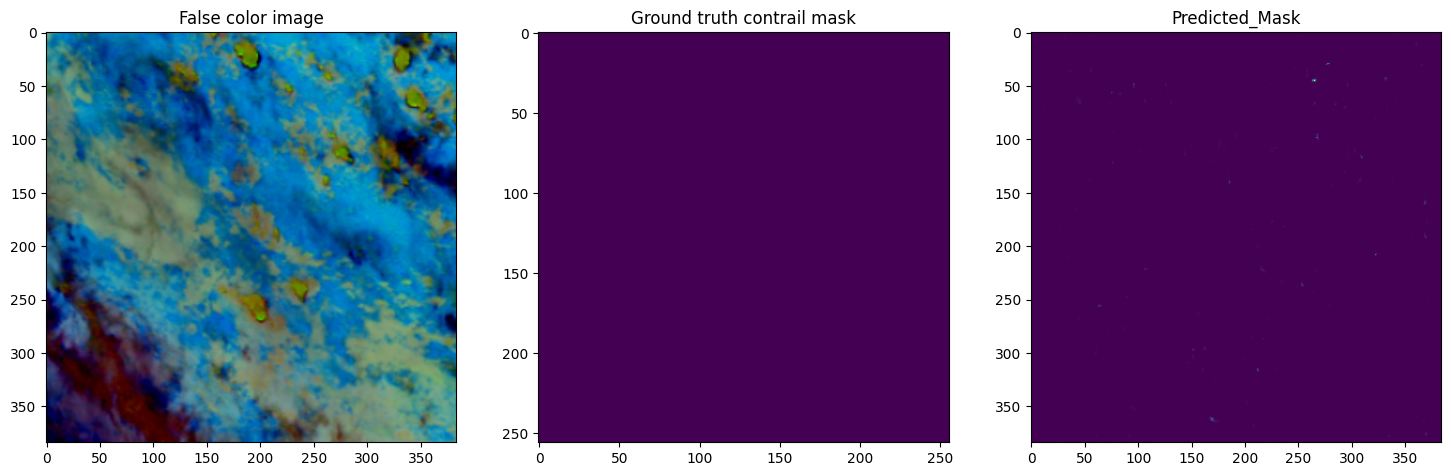

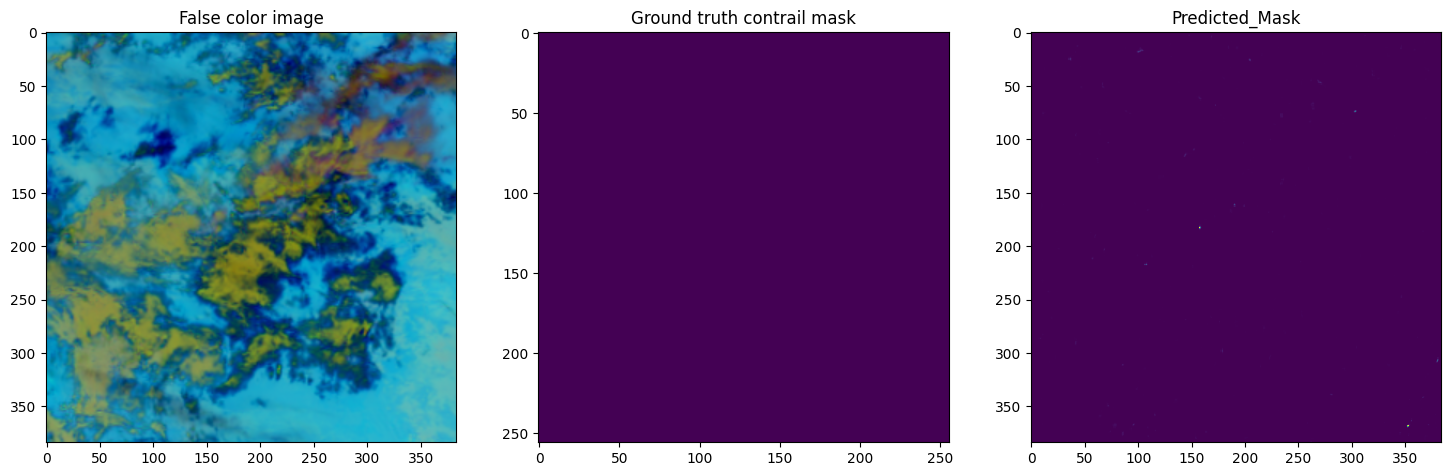

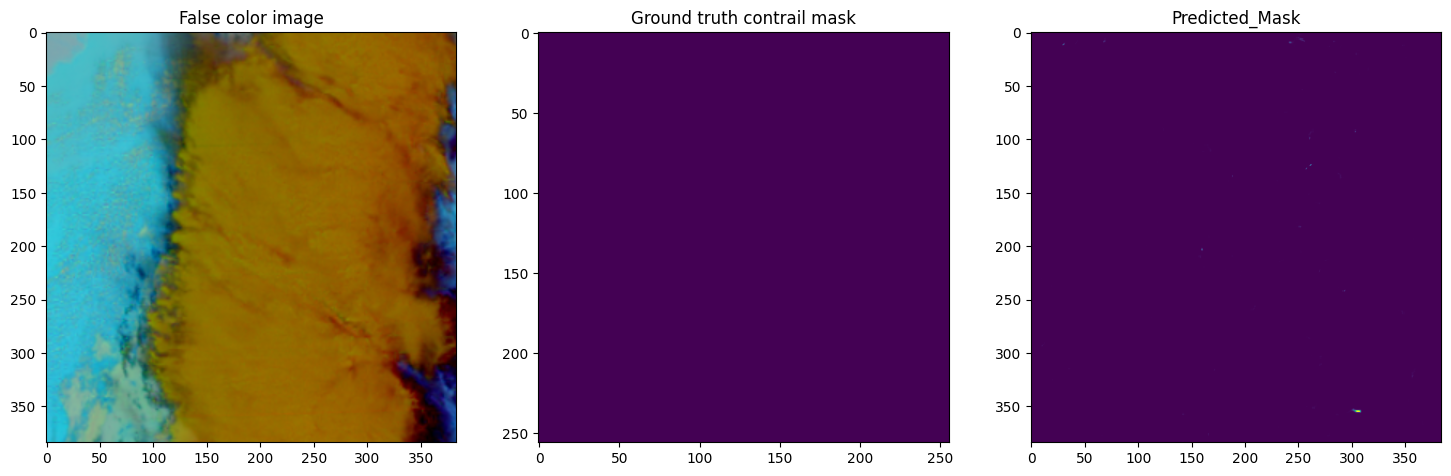

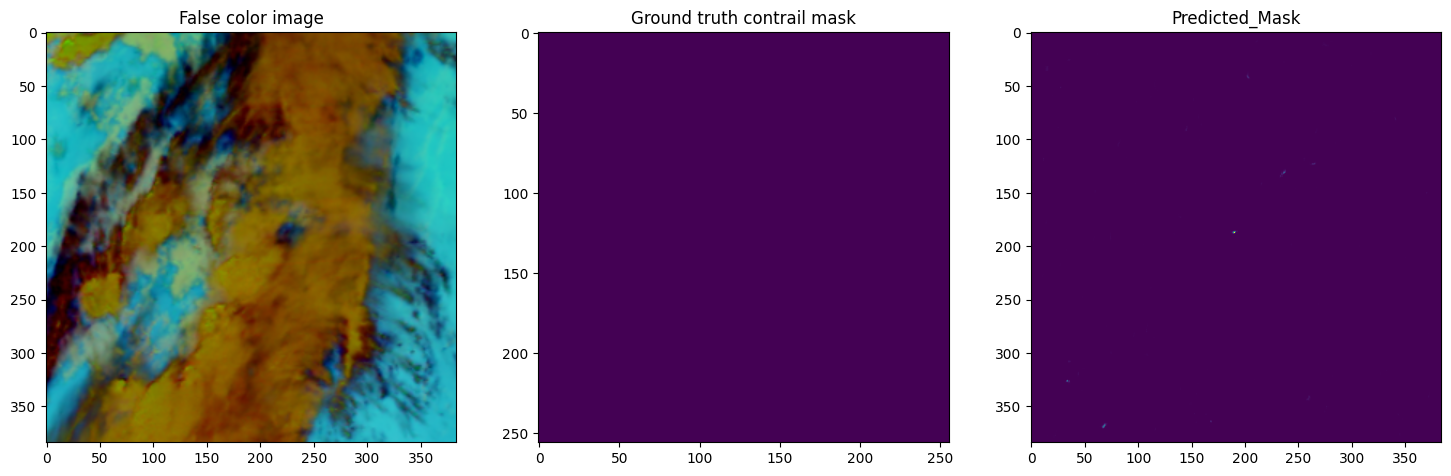

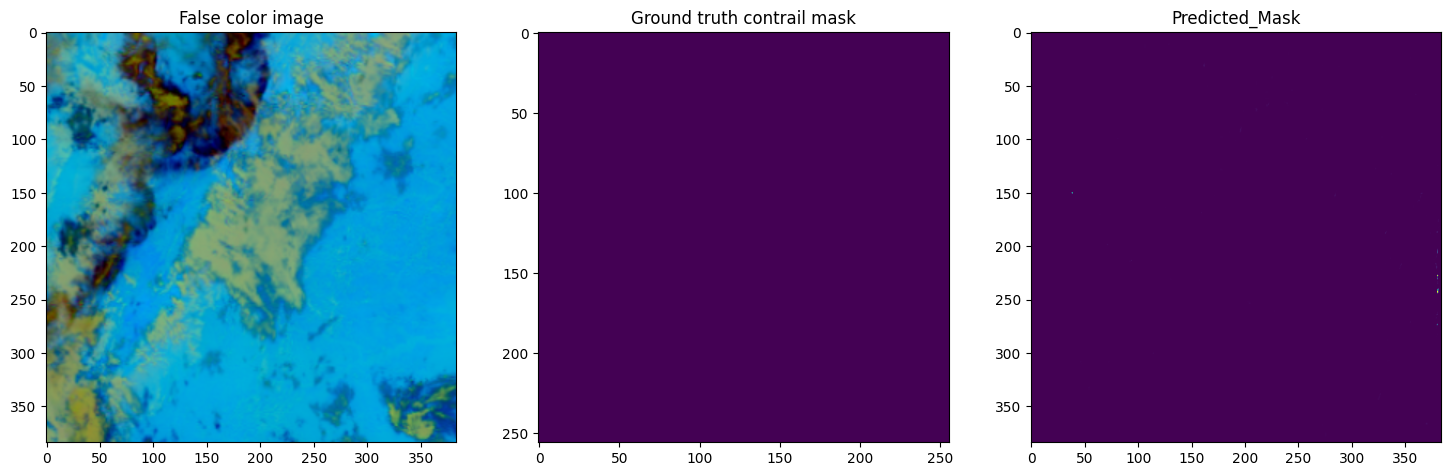

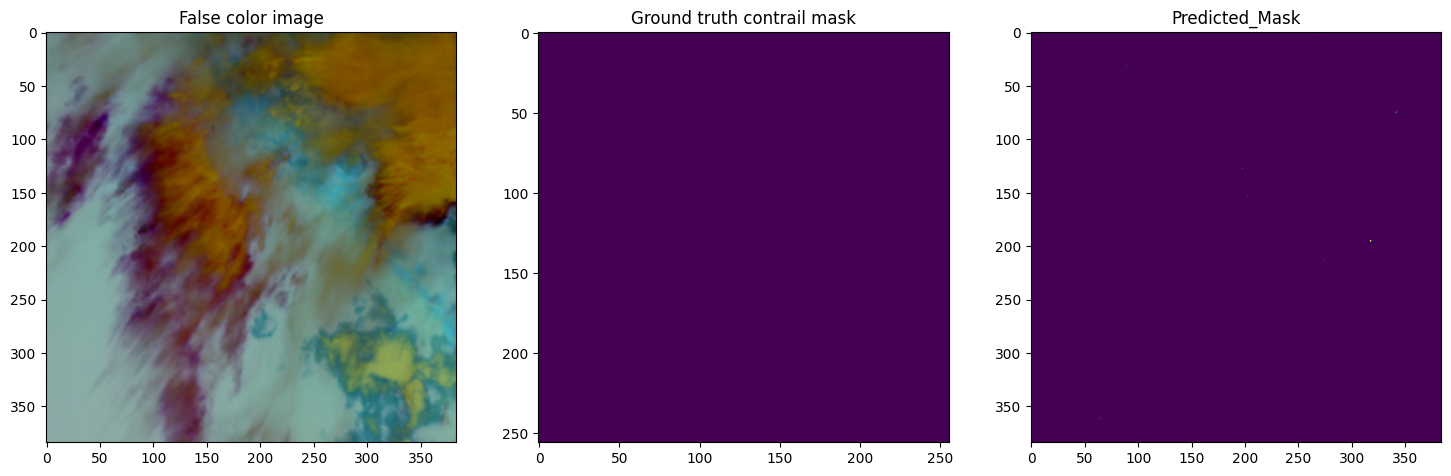

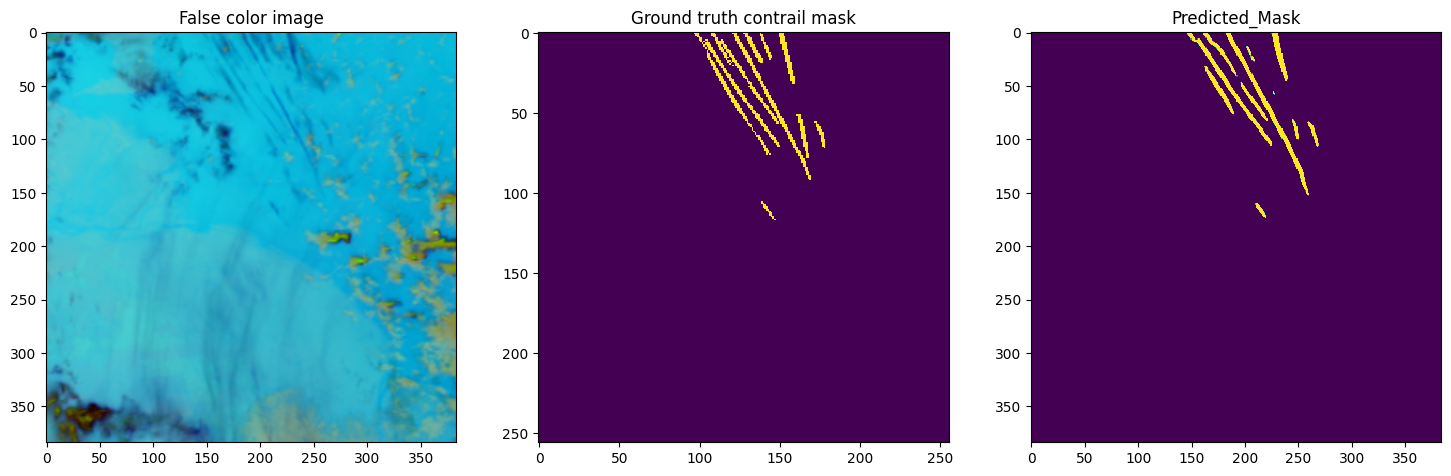

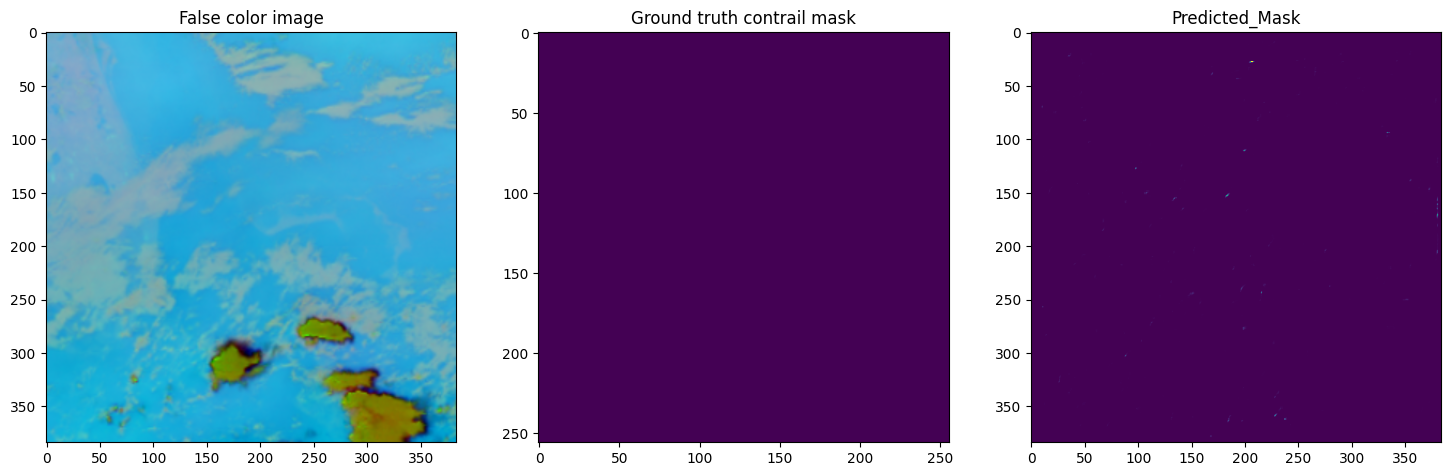

In [ ]:
model.eval()

image, mask = next(iter(validation_dataloader))

image, mask = image.to(device), mask.to(device)
logits = model(image)

image = torch.moveaxis(image,1,-1)
mask = torch.moveaxis(mask,1,-1)
logits = torch.moveaxis(logits,1,-1)

image, mask, logits = image.cpu(), mask.cpu(), logits.detach().cpu()

for i in range(CFG.batch_size):

    plt.figure(figsize=(18, 6))

    ax = plt.subplot(1, 3, 1)
    ax.imshow(image[i])
    ax.set_title('False color image')

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask[i], interpolation='none')
    ax.set_title('Ground truth contrail mask')

    ax = plt.subplot(1, 3, 3)
    ax.imshow(logits[i], interpolation='none')
    ax.set_title('Predicted_Mask')

## **Bonus: Vary the threshold for the predictions**

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

125

In [ ]:
torch.cuda.empty_cache()

bst_dice = 0
thresholds = [0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for threshold in thresholds:

    model.eval()
    bar = tqdm(validation_dataloader)

    tot_dice_avg = 0
    tot_dice_global = 0
    count = 0
    for image, mask in bar:

        if CFG.resize:
            image = torch.nn.functional.interpolate(image,
                                                size=CFG.resize_value,
                                                mode='bilinear'
                                               )
        image,mask = image.to(device), mask.to(device)
        with torch.no_grad():
            pred_mask = model(image)


        pred_mask[pred_mask >= threshold] = 1
        pred_mask[pred_mask<threshold]=0

        if CFG.resize:
            pred_mask = torch.nn.functional.interpolate(pred_mask,
                                                size=256,
                                                mode='bilinear'
                                               )

        tot_dice_avg += dice_avg(pred_mask, mask).item()
        tot_dice_global+=dice_global(pred_mask,mask).item()
        count += 1
        bar.set_postfix(ValidDiceAvg=f'{tot_dice_avg/count:.4f}',
                        ValidDiceGlobal = f'{tot_dice_global/count:.4f}')


    if tot_dice_global/count > bst_dice:
        bst_dice = tot_dice_global/count
        print(f"new best global dice: {bst_dice} for threshold: {threshold}")

  0%|          | 0/116 [00:00<?, ?it/s]

new best global dice: 0.5736158100666537 for threshold: 0.01


  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

# **Testing**

In [ ]:
!gdown --id '12YafPg9HwkfKbKnZ2GB0VR1ICesyQDYL' --output test.zip
!unzip -q test.zip

In [ ]:
model.eval()

test_record_id = ['1000834164244036115', '1002653297254493116']
test_set = torch.zeros([2, 3, 256, 256])

_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)
N_TIMES_BEFORE = 4

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

for i, id in enumerate(test_record_id):
    record_dir = os.path.join(CFG.GLOBAL_PATH, id)

    with open(os.path.join(record_dir, 'band_11.npy'), 'rb') as f:
        band11 = np.load(f)
    with open(os.path.join(record_dir, 'band_14.npy'), 'rb') as f:
        band14 = np.load(f)
    with open(os.path.join(record_dir, 'band_15.npy'), 'rb') as f:
        band15 = np.load(f)

    r = np.clip(normalize_range(band15 - band14, _TDIFF_BOUNDS), 0, 1)
    g = np.clip(normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS), 0, 1)
    b = np.clip(normalize_range(band14, _T11_BOUNDS), 0, 1)

    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)   #(256, 256, 3, 8)
    false_color = torch.from_numpy(false_color)#.clone().detach()   #torch.Size([256, 256, 3, 8])
    false_color = torch.moveaxis(false_color, -2, 0)        #torch.Size([3, 256, 256, 8])
    false_color = false_color[..., N_TIMES_BEFORE]          #torch.Size([3, 256, 256])'''

    test_set[i,:,:,:] = false_color

# Model predicts
with torch.no_grad():
    pred_logits = model(test_set.to(device))

# Determine threshold
threshold = 0.000005
pred_logits[pred_logits >= threshold] = 1
pred_logits[pred_logits < threshold] = 0

# Visualize pred results
for i in range(2):
    image = torch.moveaxis(test_set[i],0,-1)
    pred = torch.moveaxis(pred_logits[i],0,-1)

    image, pred = image.cpu(), pred.detach().cpu()

    plt.figure(figsize=(12, 6))

    ax = plt.subplot(1, 2, 1)
    ax.imshow(image)
    ax.set_title('False color image')

    ax = plt.subplot(1, 2, 2)
    ax.imshow(pred, interpolation='none')
    ax.set_title('Predicted_Mask')
